# Titanic: Machine Learning From Disaster
The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. The original dataset can be found on Kaggle: https://www.kaggle.com/competitions/titanic

## Quick Summary
The AUC results are as follows:
* Decision tree       0.8667
* Logistic regression 0.8759
* Linear regression.  0.8765
* Graident Boost      0.86
* Random Forest       0.8503
* Knn                 0.645

## Train Data
Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and whether they survive or not. The shape of the train data is (891, 12). 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from statistics import mean
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn import ensemble
import sklearn.metrics as metrics
import time

train=r'/kaggle/input/titanic/train.csv'
test=r'/kaggle/input/titanic/test.csv'

df=pd.read_csv(train)
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Feature Engineer

In [3]:
replace_dict= {'female':0,'male':1}
df['Sex']=df['Sex'].map(replace_dict)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


## Examine Target Variable
Survived is the Y variable we will be analyzing.

In [4]:
temp=df['Survived'].value_counts()
print(temp)
no=temp[0]
yes=temp[1]
percent=round(yes/(yes+no),3)
print("Percent that died: ", percent)

0    549
1    342
Name: Survived, dtype: int64
Percent that died:  0.384


## Numeric DataFrame
For now, we will analyze only numeric values. Categorical values will need to be encoded or analyzed individually.

In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include=numerics)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,1,22.0,1,0,7.2500
1,2,1,1,0,38.0,1,0,71.2833
2,3,1,3,0,26.0,0,0,7.9250
3,4,1,1,0,35.0,1,0,53.1000
4,5,0,3,1,35.0,0,0,8.0500


## Check for missing values
Age is missing around 20% of values.Therefore, we can simply fill in the mean for that one column.

In [6]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head())
findNA() 

Missing data by column as a percent:
Age            0.198653
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Sex            0.000000
dtype: float64


In [7]:
df= df.fillna(df.mean())

## Split Data

In [8]:
X=df.drop('Survived', axis=1)
y=df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

## Highly Correlated Features
There are no highly correlated variables above 80%. Therefore, we do not need to worry about removing variables that are too highly correlated. 

## Gradient Boost with Feature Importance

In [9]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor

params = {
 "n_estimators": 500, "max_depth": 4, "min_samples_split": 5, "learning_rate": 0.01,
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
gbr_r2 = r2_score(y_test, y_pred).round(4) 
print("Gradient boosting regression r2: ", gbr_r2) 

#calculate AUC of model
auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("AUC for gradient boost is: ", auc)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Gradient boosting regression r2:  0.422
AUC for gradient boost is:  0.8612
The mean squared error (MSE) on test set: 0.1402


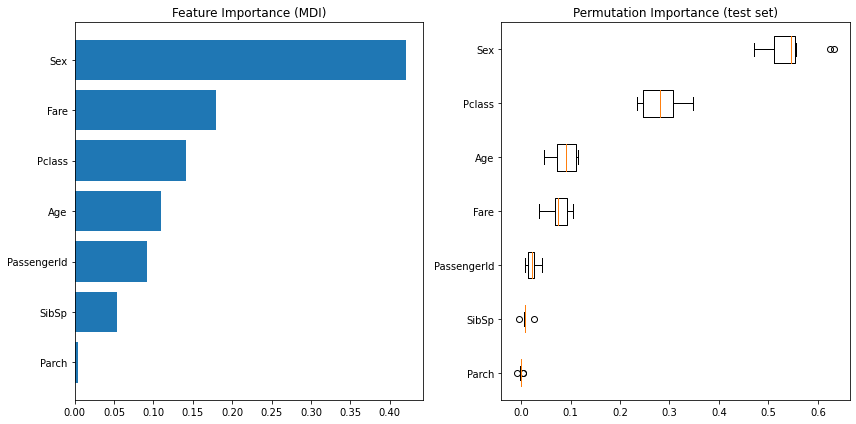

In [10]:
#FEATURE IMPORTANCE:
cols=X.columns
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(cols)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(solver='liblinear') #solver param gets rid of encoder error

#Train the model and create predictions
logReg.fit(X_train, y_train)
logPredict = logReg.predict_proba(X_test)[::,1]

#calculate AUC of model
auc = round( metrics.roc_auc_score(y_test, logPredict), 4 ) 
print("AUC for logistic regression is: ", auc)

AUC for logistic regression is:  0.8759


## Linear Regression

AUC for linear regression is:  0.8765
Linear regression r2 score:  0.4424
Linear Accuracy:  0.4424
0.3665  linear regression cross validate mean


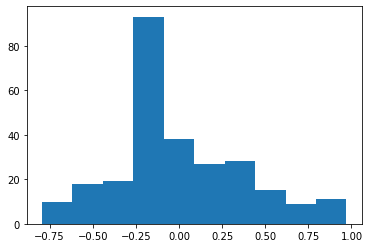

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#Fit and predict:
lrModel = LinearRegression()
lrModel.fit(X_train, y_train)
lrPredict = lrModel.predict(X_test)

# plt.scatter(y_test, predictions)
plt.hist(y_test - lrPredict)

#Linear Metrics:
auc = round( metrics.roc_auc_score(y_test, lrPredict), 4 ) 
r2 = r2_score(y_test, lrPredict).round(4) 
print("AUC for linear regression is: ", auc)
print("Linear regression r2 score: ", r2)

#CROSS VALIDATE TEST RESULTS:
lr_score = lrModel.score(X_test, y_test).round(4)  # train test 
print("Linear Accuracy: ", lr_score)
lr_cv = cross_validate(lrModel, X, y, cv = 5, scoring= 'r2')
lr_cvMean=lr_cv['test_score'].mean().round(4)
print(lr_cvMean, " linear regression cross validate mean")

def linearReports():
    print(model.coef_)    
    print(model.intercept_)
    print(classification_report(y_test_data, lrPredict))
    print(confusion_matrix(y_test_data, lrPredict))
    metrics.mean_absolute_error(y_test, lrPredict)
    lrMSE=np.sqrt(metrics.mean_squared_error(y_test, lrPredict))
    print(round(lrMSE, 4), " is lr MSE ")

## Decision Tree

In [13]:
from sklearn.tree import DecisionTreeRegressor

#FIND best_tree_size LEAF NODES:
def calcLeaf():
    candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
    maeDic={} #dictionary  key=leaf  mae=value
    for leaf in candidate_max_leaf_nodes:
        model = DecisionTreeRegressor(max_leaf_nodes=leaf, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[leaf]=mae
    print(maeDic)
    best_tree_size = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_tree_size)
    
def calcDepth():
    max_depth_list = [2, 3, 5, 7, 9, 10, 12]
    maeDic={} #dictionary  key=depth  mae=value
    for d in max_depth_list:
        model = DecisionTreeRegressor(max_leaf_nodes=100, max_depth=d, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[d]=mae
    print(maeDic)
    best_max_depth = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_max_depth, " best max_depth with least error.") #10
    
def automateTree():
    print("Decision Tree Automating:")
    start=time.time()
    candidate_max_leaf_nodes = [5, 25, 50, 75, 100, 150, 250, 400, 500]
    max_depth_list = [2, 3, 5, 7, 9, 10, 11]
    
    #STORE DATA INTO LISTS FOR DATAFRAME LATER:
    aucList=[]
    maeList=[]
    maxDepthList=[]
    maxLeafNodesList=[]

    for d in max_depth_list:
        for leaf in candidate_max_leaf_nodes:
            model = DecisionTreeRegressor(max_leaf_nodes=leaf, max_depth=d, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred).round(4)
            treeR2 = r2_score(y_test, y_pred).round(4)
            
            aucList.append(treeR2)
            maeList.append(mae)
            maxDepthList.append(d)
            maxLeafNodesList.append(leaf)
           
    df = pd.DataFrame(list(zip(aucList, maeList, maxDepthList, maxLeafNodesList)),
                          columns=['AUC','MAE', 'MaxDepth', 'MaxLeafNodes'])
    
    df=df.sort_values(by=['AUC'], ascending=False)
    print("Done. ", round(time.time()-start,4), " seconds")
    return df
    
treeDF=automateTree()    
treeDF.head()

Decision Tree Automating:
Done.  0.3366  seconds


,AUC,MAE,MaxDepth,MaxLeafNodes
45,0.3782,0.2743,10,5
18,0.3782,0.2743,5,5
54,0.3782,0.2743,11,5
27,0.3782,0.2743,7,5
36,0.3782,0.2743,9,5


In [14]:
best_tree_size=5
best_depth=3
    
#MAKE PREDICTION:
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X, y)
y_pred = tree.predict(X_test)

#AUC and r2 metric:
treeR2 = r2_score(y_test, y_pred).round(4)
print(treeR2, " R2 Decision Tree")
treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("AUC for decision tree is: ", treeAUC)

def printReports(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    treeMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print(round(treeMSE, 4), " is tree MSE ")

0.4549  R2 Decision Tree
AUC for decision tree is:  0.8667


## Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor

#Check for Error and find Best n_estimators:
def checkMAE():
    print("Starting MAE:")
    dMAE={} #dictionary of n_estimators as key and MAE as value:
    for n in range(2, 501, 50):
        forest = RandomForestRegressor(n_estimators=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        print("Random forest AUC: ", forest_auc) 
        dMAE[n]=MAE
        print("n_estimates: ", n,  '  Mean Absolute Error:', MAE)

    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)
    print(dMAE)
#checkMAE() #turn function on or off by uncommenting

In [16]:
def forest(num):
    forest = RandomForestRegressor(n_estimators=num, random_state = 0)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)

    #Print Metrics:
    forest_r2 = r2_score(y_test, y_pred).round(4)  
    forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
    print("Random forest AUC: ", forest_auc) 
    print("Random forest r2: ", forest_r2)

def forestReports():
    mae=metrics.mean_absolute_error(y_test, y_pred).round(2)
    print("Random forest MAE: ", mae)
    
forest(400)

Random forest AUC:  0.8503
Random forest r2:  0.3877


## K-Nearest Neighbors (KNN)

In [17]:
from sklearn.neighbors import KNeighborsClassifier

def knnError():
    print("Finding best n_neighbors value:")
    error_rates = []
    for i in range(1, 10, 2): #Must be an odd number to break a tie
        new_model = KNeighborsClassifier(n_neighbors = i)
        new_model.fit(X_train, y_train)
        new_predictions = new_model.predict(X_test)
        error_rates.append(np.mean(new_predictions != y_test))
    plt.figure(figsize=(16,12))
    plt.plot(error_rates)

def knnModel():
    #Train the model and make predictions:
    knn = KNeighborsClassifier(n_neighbors =5) 
    knn.fit(X_train, y_train)
    knnPredict = knn.predict_proba(X_test)[::,1]

    #calculate AUC of model
    knn_auc = round( metrics.roc_auc_score(y_test, knnPredict), 4 ) 
    print("Knn AUC: ", knn_auc)

def knnReports():
    acc = metrics.accuracy_score(y_test_data, knnPredict)
    print(confusion_matrix(y_test, knnPredict))
    print(classification_report(y_test, knnPredict))
    print(confusion_matrix(y_test, knnPredict))
knnModel()

Knn AUC:  0.645


# Test Data

In [18]:
test=pd.read_csv(test)
features=list(X.columns)
test=test[features]
replace_dict= {'female':0,'male':1}
test['Sex']=test['Sex'].map(replace_dict)
test=test.fillna(test.mean())
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,1,34.5,0,0,7.8292
1,893,3,0,47.0,1,0,7.0000
2,894,2,1,62.0,0,0,9.6875
3,895,3,1,27.0,0,0,8.6625
4,896,3,0,22.0,1,1,12.2875


## Make Final Prediction

In [19]:
test_predictions = logReg.predict(test)
#test_predictions=np.where(test_predictions<.5, 0, test_predictions)
#test_predictions=np.where(test_predictions>.5, 1, test_predictions)
passID=test['PassengerId']
tupleData = list(zip(passID, test_predictions))
output = pd.DataFrame(tupleData, columns = ['PassengerId', 'Survived'])
output.head(15)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [20]:
sample=r'/kaggle/input/titanic/gender_submission.csv'
sample=pd.read_csv(sample)
sample.head(15)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


## Submit Predictions

In [21]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
